# Initial processing & industry EDA

In this notebook, we will take some initial steps to prepare the organizational data for modeling, including adding an `age`, `continent_code`, and 46 indicator columns to track company industries.

**7 CSV files are created from this notebook**

- `df` $\rightarrow$ `files/output/organizations_merged.csv` -- Organizations with Pledge 1% tag information
- `p1_jobs` $\rightarrow$ `files/output/p1_jobs.csv`-- Jobs with Pledge 1% tag information for the affiliated companies
- `p1_fun` $\rightarrow$ `files/output/p1_funding_rounds.csv` -- Funding rounds with Pledge 1% tag information for the funded companies
- `p1_inv` $\rightarrow$ `files/output/p1_investments.csv`-- Investments with Pledge 1% tag information for the funded companies
- `p1_part` $\rightarrow$ `files/output/p1_investment_partners.csv` -- Partner investments with Pledge 1% tag information for the funded companies
- `pledge1_industry` $\rightarrow$ `files/output/p1_by_category_group.csv` -- P1 organizations' `uuid` with 46 indicator columns that correspond to their `category_groups_list`
- `df_industry` $\rightarrow$ `files/output/organizations_by_category_group.csv` -- Organizations' `uuid` with 46 indicator columns that correspond to their `category_groups_list`

In [68]:
# Add 'graph' environment to PATH
import sys
sys.path.append('/home/ski/anaconda3/envs/graph/lib/python3.8/site-packages')

# User defined functions
import base_methods
from importlib import reload
from base_methods import load_the_csvs, reformat_large_tick_values, column_formatter

# Import data analysis packages
import numpy as np
import pandas as pd
import warnings
import time
import math
from datetime import datetime
from random import randint
warnings.filterwarnings('ignore')

# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
sns.set(font_scale=1.3)
sns.set_style("white") 

# Country converter
import pycountry_convert as pc
def country_to_continent(country_name):
    '''
    To reduce the feature space of the 210 countries available in Crunchbase,
    Explore collapsing into continent field instead.
    '''
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    except:
        country_alpha2 = 'Unknown'
    try:
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    except:
        country_continent_code = 'Unknown'
    if country_continent_code == 'NA':
        country_continent_code = 'NorAm'
    return country_continent_code

### Loading data

Data sourced from the <a href='https://www.crunchbase.com/'>Crunchbase API</a> via Pledge 1%'s Enterprise License Agreement.

In [69]:
# Store path to notebook
PWD = !pwd
PWD = PWD[0]

# Set global paths to data folders
!mkdir {PWD}/files/output/
print()
INPUT = PWD + '/files/csv/'
OUTPUT = PWD + '/files/output/'

# Load
p1,org,fun,inv,part,jobs = load_the_csvs(loc=INPUT, 
                                         data=['p1','organizations','funding_rounds',
                                               'investments','investment_partners','jobs'],
                                         verbose=True)

mkdir: cannot create directory ‘/home/ski/Desktop/crunchbase-p1-machine-learning/files/output/’: File exists

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/CSV/P1.CSV
P1 shape: (7822, 3)
P1 columns: ['uuid', 'p1_tag', 'p1_date']

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/CSV/ORGANIZATIONS.CSV
ORGANIZATIONS shape: (1131310, 41)
ORGANIZATIONS columns: ['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at', 'updated_at', 'legal_name', 'roles', 'domain', 'homepage_url', 'country_code', 'state_code', 'region', 'city', 'address', 'postal_code', 'status', 'short_description', 'category_list', 'category_groups_list', 'num_funding_rounds', 'total_funding_usd', 'total_funding', 'total_funding_currency_code', 'founded_on', 'last_funding_on', 'closed_on', 'employee_count', 'email', 'phone', 'facebook_url', 'linkedin_url', 'twitter_url', 'logo_url', 'alias1', 'alias2', 'alias3', 'primary_role', 'num_exits']

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/

### Check out fields of relevant dataframes.

We will only keep the following columns for each dataset and re-save them for easier access in future steps.

#### Pledge 1% -- `p1`
    ['uuid', 'p1_tag', 'p1_date']
    
#### Organizations -- `org`
    ['uuid', 'name', 'type', 'rank', 'roles', 'country_code', 'region', 'status', 'category_groups_list', 'total_funding_usd', 'founded_on', 'closed_on', 'employee_count', 'primary_role']

#### Funding Rounds -- `fun`

    ['uuid', 'lead_investor_uuids', 'org_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd',  'investor_count', 'lead_investor_count', 'org_name']
    
#### Investments -- `inv `

    ['uuid', 'funding_round_uuid', 'investor_uuid', 'investor_name', 'investor_type', 'is_lead_investor']
    
#### Partner Investments -- `part`

    ['uuid', 'funding_round_uuid', 'investor_uuid', 'partner_uuid', 'investor_name', 'partner_name']

#### Jobs -- `jobs`

    ['uuid', 'person_uuid', 'org_uuid', 'job_type', 'person_name', 'org_name', 'title', 'is_current', 'started_on', 'ended_on']

In [70]:
# Update dataframe columns
org = org[['uuid', 'name', 'type', 'rank', 'roles', 'country_code', 'region', 'status', 
           'category_groups_list', 'total_funding_usd', 'founded_on', 'closed_on',
           'employee_count', 'primary_role']]
fun['lead_investor_count']=fun['lead_investor_uuids'].str.split(',').apply(lambda x: float(len(x)) if ~np.any(pd.isnull(x)) else 0)
fun = fun[['uuid', 'lead_investor_uuids', 'org_uuid', 'investment_type', 
           'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 
           'investor_count', 'lead_investor_count', 'org_name']]
inv = inv[['uuid', 'funding_round_uuid', 'investor_uuid', 'investor_name', 'investor_type', 'is_lead_investor']]
part = part[['uuid', 'funding_round_uuid', 'investor_uuid', 'partner_uuid', 'investor_name', 'partner_name']]
jobs = jobs[['uuid', 'person_uuid', 'org_uuid', 'job_type', 'person_name', 'org_name', 
             'title', 'is_current', 'started_on', 'ended_on']]
p1['p1_tag'] = 1

#### Create `df` dataframe

Organizations with Pledge 1% tag information 

In [71]:
# Merge p1 and org dataframes on the organization uuid
df = pd.merge(org, p1, how='left', on='uuid').reset_index(drop=True)

# Update column types
df = column_formatter(df)

# Add age variable to baseline
now = datetime(2020, 9, 8).date() # 'now' represents when the data export took place (September 9, 2020)
df['founded_on'] = pd.to_datetime(df['founded_on']).dt.date
age = []
for i in range (len(df['founded_on'])):
    if not pd.isna(df['founded_on'][i]):
        val = now - df['founded_on'][i]
        if val.days >= 0:
            age.append(round(((val.days)/365)))
        else:
            age.append(np.NaN)
    else:
        age.append(np.NaN)
df['age'] = pd.Series(age)

# Add continent variable to baseline
countries = df.country_code.unique().tolist()
d = pc.map_countries(cn_name_format="default")
d = {v['alpha_3']:k for k,v in d.items()}
d = {k:country_to_continent(v) for k,v in d.items() if k in countries}
df['continent_code'] = df['country_code'].map(d)
df['continent_code'].replace('Unknown', np.NaN, inplace=True)

# Output
df.to_csv(OUTPUT + 'organizations_merged.csv', index=False)
print(f'OUTPUT TO CSV {OUTPUT}')

del org, p1

OUTPUT TO CSV /home/ski/Desktop/crunchbase-p1-machine-learning/files/output/


#### Create `p1_jobs` dataframe

Jobs with Pledge 1% tag information for the affiliated companies

In [6]:
# Load in data
p1 = load_the_csvs(loc=INPUT, verbose=False)
p1['p1_tag'] = 1
p1['org_uuid'] = p1['uuid']
p1.drop('uuid', axis=1, inplace=True)

# Merge jobs and p1 dataframes on the organization uuid
p1_jobs = pd.merge(jobs, p1, how='left', on='org_uuid')

# Column updates
p1_jobs.rename({'uuid':'job_uuid'}, axis=1, inplace=True)

# Update column types
p1_jobs = column_formatter(p1_jobs)

# Output
p1_jobs.to_csv(OUTPUT + 'p1_jobs.csv', index=False)
print(f'OUTPUT TO CSV {OUTPUT}')

del p1_jobs, jobs, p1

OUTPUT TO CSV /home/ski/Desktop/crunchbase-p1-machine-learning/files/output/


#### Create `p1_fun` dataframe

Funding rounds with Pledge 1% tag information for the funded companies

In [7]:
# Load in data
p1 = load_the_csvs(loc=INPUT, verbose=False)
p1['p1_tag'] = 1
p1['org_uuid'] = p1['uuid']
p1.drop('uuid', axis=1, inplace=True)

# Merge funding rounds and p1 dataframes on the organization uuid
p1_fun = pd.merge(fun, p1, how='left', on='org_uuid')

# Column updates
p1_fun.rename({'uuid':'funding_round_uuid'}, axis=1, inplace=True)

# Update column types
p1_fun = column_formatter(p1_fun)

# Output
p1_fun.to_csv(OUTPUT + 'p1_funding_rounds.csv', index=False)
print(f'OUTPUT TO CSV {OUTPUT}')

del p1

OUTPUT TO CSV /home/ski/Desktop/crunchbase-p1-machine-learning/files/output/


#### Create `p1_inv` dataframe

Investments with Pledge 1% tag information for the funded companies

In [8]:
# Merge investents and p1 funding rounds dataframes on the funding round uuid
p1_inv = pd.merge(inv, p1_fun, how='left', on='funding_round_uuid')

# Column updates
p1_inv.rename({'uuid':'investment_uuid'}, axis=1, inplace=True)

# Update column types
p1_inv = column_formatter(p1_inv)

# # Output
p1_inv.to_csv(OUTPUT + 'p1_investments.csv', index=False)
print(f'OUTPUT TO CSV {OUTPUT}')

del p1_inv, inv

OUTPUT TO CSV /home/ski/Desktop/crunchbase-p1-machine-learning/files/output/


#### Create  `p1_part` dataframe

Partner investments with Pledge 1% tag information for the funded companies

In [9]:
# Merge partner investments and p1 funding rounds dataframes on the funding round uuid
p1_part = pd.merge(part, p1_fun, how='left', on='funding_round_uuid')

# Column updates
p1_part.rename({'uuid':'investment_uuid'}, axis=1, inplace=True)

# Update column types
p1_part = column_formatter(p1_part)

# Output
p1_part.to_csv(OUTPUT + 'p1_investments_partner.csv', index=False)
print(f'OUTPUT TO CSV {OUTPUT}')

del p1_fun, p1_part, part

OUTPUT TO CSV /home/ski/Desktop/crunchbase-p1-machine-learning/files/output/


### Missing data in `df`

In [10]:
df_num_missing = df.isna().sum()/len(df)
output = df_num_missing.to_string(float_format=lambda x: "{:.2f}%".format(x*100))

print('MISSING CB VALUES BY PERCENTAGE\n')
print(output)

del df_num_missing

MISSING CB VALUES BY PERCENTAGE

uuid                    0.00%
name                    0.00%
type                    0.00%
rank                    4.13%
roles                   0.73%
country_code           17.04%
region                 17.04%
status                  0.00%
category_groups_list    8.72%
total_funding_usd      88.25%
founded_on             22.34%
closed_on              98.95%
employee_count         27.58%
primary_role            0.00%
p1_tag                  0.00%
p1_date                99.31%
age                    22.34%
continent_code         17.30%


### Missing data in `pledge1`

In [11]:
p1_num_missing = df[df['p1_tag']==1].isna().sum()/len(df[df['p1_tag']==1])
output = p1_num_missing.to_string(float_format=lambda x: "{:.2f}%".format(x*100))

print('MISSING PLEDGE 1% VALUES BY PERCENTAGE\n')
print(output)

del p1_num_missing, output

MISSING PLEDGE 1% VALUES BY PERCENTAGE

uuid                    0.00%
name                    0.00%
type                    0.00%
rank                    0.20%
roles                   0.20%
country_code            8.90%
region                  8.90%
status                  0.00%
category_groups_list    3.68%
total_funding_usd      71.48%
founded_on             12.27%
closed_on              99.04%
employee_count         16.01%
primary_role            0.00%
p1_tag                  0.00%
p1_date                 0.00%
age                    12.27%
continent_code          9.01%


### Note on missing data


For any of the features used in modeling, we will need to impute any missing information. There are 124 Pledge 1% companies that are 'closed', and  36,777 (3.25%) in Crunchbase. See imputation notebook for more details.


#### `rank` -- a possible proxy for prominience or popularity of a company?

<a href="https://about.crunchbase.com/blog/crunchbase-rank-trend-score/">More on Rank Score</a>

    Crunchbase Rank is a dynamic ranking for all entities (i.e., Companies, Organizations, and Schools) in the Crunchbase dataset. It measures the prominence of an entity.

    The Crunchbase Rank algorithm takes many signals into account including the number of connections a profile has, the level of community engagement, funding events, news articles, and acquisitions.

    A company’s Rank is fluid and subject to rising and decaying over time with time-sensitive events. Events such as product launches, funding events, leadership changes, and news affect a company’s Crunchbase Rank.

### Note on feature engineering

Transform `employee_count` string-type field to an ordinal feature.
- 1-10 $\rightarrow$ 1 
- 11-50 $\rightarrow$ 2
- 51-100 $\rightarrow$ 3
- 101-250 $\rightarrow$ 4
- 251-500 $\rightarrow$ 5
- 501-1000 $\rightarrow$ 6
- 1001-5000 $\rightarrow$ 7
- 5001-10000 $\rightarrow$ 8
- 10000+ $\rightarrow$ 9

Transform `category_groups_list` list of string into separate indicator (0,1) columns



##  Industry differences between Crunchbase and Pledge 1%

Create 46 industry indicator columns from `category_groups_list`

In [12]:
# Category Group list
# Merge category_list column into one string, convert to unique list
groups = list(set(df.category_groups_list.str.cat(sep=',').split(',')))
print('Number of unique category groups:',len(groups))

# Create pledge1 dataframe
pledge1 = df[df['p1_tag']==1]

Number of unique category groups: 46


#### Create `pledge1_industry` dataframe

P1 organizations' uuid with 46 indicator columns that correspond to their `category_groups_list`

In [13]:
# Start timer
start = time.time()

# Create a new dataframe with a column for each unique category group, fill those with zeros
pledge1_industry = pd.concat([pledge1[~pledge1['category_groups_list'].isna()][['uuid']],pd.DataFrame(columns=groups)]).fillna(0)

# Clean up, reset index
pledge1_industry.reset_index(inplace=True, drop=True)

# Combine all category_groups_list values into a list
Categories = pledge1['category_groups_list'][~pledge1['category_groups_list'].isna()].to_list()

# Populate the matrix
for i in range(pledge1_industry.shape[0]): # By each organization
    row_category_list = Categories[i].split(',') # For each category group
    for industry in row_category_list:
        pledge1_industry[industry][i] = 1 # Update to 1
    
# Create total row & column
pledge1_industry.loc['total',:] = pledge1_industry.sum(axis = 0) # row
pledge1_industry.loc[:,'total'] = pledge1_industry.sum(axis = 1) # columns

# Replace concatenated string field at the bottom of the dataframe
pledge1_industry.iloc[pledge1_industry.shape[0]-1,0] = 'total'

# Sort columns of a dataframe in descending order, by Total row
rslt_df = pledge1_industry[pledge1_industry.columns.to_list()[1:-1]].sort_values(by ='total', axis=1, ascending=False)

# Update dataframe with sorted columns, keeping uuid and total columns in place
pledge1_industry = pd.concat([pledge1_industry[['uuid']],rslt_df,pledge1_industry[['total']]], axis=1)

# End timer
print('This took {:.4f} seconds to run.'.format(time.time()-start))

# Create list of sorted columns
groups_sorted = pledge1_industry.columns[1:-1].to_list()

# Output
pledge1_industry.to_csv(OUTPUT + 'p1_by_category_group.csv', index=False)
print(f'OUTPUT TO CSV {OUTPUT}')

# Check it out
pledge1_industry.tail(2)

This took 1.2632 seconds to run.
OUTPUT TO CSV /home/ski/Desktop/crunchbase-p1-machine-learning/files/output/


,uuid,Software,Information Technology,Internet Services,Data and Analytics,Sales and Marketing,Media and Entertainment,Commerce and Shopping,Financial Services,Apps,...,Messaging and Telecommunications,Energy,Platforms,Gaming,Government and Military,Biotechnology,Navigation and Mapping,Agriculture and Farming,Natural Resources,total
7533,66166dce-a4d1-4f52-93ec-4cee3d369af6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
total,total,3546.0,1868.0,1525.0,1077.0,1005.0,949.0,922.0,920.0,832.0,...,129.0,125.0,115.0,111.0,107.0,90.0,81.0,79.0,75.0,23486.0


#### Create `df_industry` dataframe

Organizations' uuid with 46 indicator columns that correspond to their `category_groups_list`

In [14]:
###########################################################################################
# STEP 1: Create empty matrix, columns in same order as the Pledge 1% industry dataframe. #
###########################################################################################

# Start timer
start = time.time()

# Create a column for each unique category group, fill with zeros
df_industry = pd.concat([df[~df['category_groups_list'].isna()][['uuid']],pd.DataFrame(columns=groups_sorted)]).fillna(0) # Keep copy()?

# Clean up, reset index
df_industry.reset_index(inplace=True, drop=True)

# End timer
print('STEP 1 -- This takes {:.4f} seconds to run.\n'.format(time.time()-start))

################################################################################################
# STEP 2: The dataframe is too large; loop over segments of 10K rows to populate empty matrix. #
################################################################################################

# Start timer
start=time.time()

# For print statements
counter = 1

# For looping
iteration = 0
loop = 10000

# Empty list to append 10K dataframes into
frames = []

# Combine all category_groups_list values into a list
Categories = df['category_groups_list'][~df['category_groups_list'].isna()].to_list()

# Start loop
print('STEP 2 Counting to',math.ceil(df['category_groups_list'][~df['category_groups_list'].isna()].shape[0]/loop),'--', end=' ')

# Continue until you've iterated through entire dataframe
while iteration < df['category_groups_list'][~df['category_groups_list'].isna()].shape[0]: # ~1M in size
    
    # Create temporary sub-list of categories
    Categories_temp = Categories[iteration:iteration+loop]
    
    # Create temporary smaller empty matrix dataframe
    df_temp = df_industry.iloc[iteration:iteration+loop,:]
    
    # Populate the matrix
    for i in range(df_temp.shape[0]): # By each organization
        row_category_list = Categories_temp[i].split(',') # For each category group
        for industry in row_category_list:
            df_temp[industry][iteration+i] = 1 # Update to 1
    
    # Output progress of loop
    print(counter,end=' ')
    
    # Update counter and iterations
    counter += 1
    iteration += loop
    
    # Append new dataframe to list
    frames.append(df_temp)

# End timer
print('-- This takes {:.4f} seconds to run.\n'.format(time.time()-start))

# Combine all dataframes together.
df_industry = pd.concat(frames)

#######################################
# STEP 3+4: Add total column and row. #
#######################################

# CREATE TOTAL COLUMN
print('STEP 3 / ROW Counting to',math.ceil(df_industry.shape[0]/10000),'--',end=' ')

# Start timer
start=time.time()

# Add to dataframe
totals_column = np.zeros(df_industry.shape[0])
for i in range(df_industry.shape[0]):
    if i % 10000 == 0:
        print(int((i/10000)+1), end=' ')
    totals_column[i] = df_industry.iloc[i,1:-1].values.sum()
df_industry['total'] = totals_column.astype('int64')

# End timer
print('-- This takes {:.4f} seconds to run.\n'.format(time.time()-start))

# CREATE TOTAL ROW
print('STEP 4 / COLUMN --', end=' ')

# Start timer
start=time.time()

# Add to dataframe
df_industry_totals = np.zeros(len(df_industry.columns[1:]))
for i in range(len(df_industry.columns)-1):
    df_industry_totals[i] = df_industry.iloc[:,i+1].values.sum()
df_industry.loc['total',1:] = df_industry_totals

# End timer
print('This takes {:.4f} seconds to run.\n'.format(time.time()-start))

# Replace concatenated string field at the bottom of the dataframe
df_industry.iloc[df_industry.shape[0]-1,0] = 'total'

# Output
df_industry.to_csv(OUTPUT + 'organizations_by_category_group.csv', index=False)
print(f'OUTPUT TO CSV {OUTPUT}')

# Check it out
df_industry.tail(2)

STEP 1 -- This takes 7.0853 seconds to run.

STEP 2 Counting to 104 -- 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 -- This takes 162.0665 seconds to run.

STEP 3 / ROW Counting to 104 -- 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 -- This takes 133.4027 seconds to run.

STEP 4 / COLUMN -- This takes 0.4383 seconds to run.

OUTPUT TO CSV /home/ski/Desktop/crunchbase-p1-machine-learning/files/output/


,uuid,Software,Information Technology,Internet Services,Data and Analytics,Sales and Marketing,Media and Entertainment,Commerce and Shopping,Financial Services,Apps,...,Messaging and Telecommunications,Energy,Platforms,Gaming,Government and Military,Biotechnology,Navigation and Mapping,Agriculture and Farming,Natural Resources,total
1032612,f87e012f-5723-481c-ac92-5993064a24ca,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
total,total,279092.0,183944.0,157851.0,58559.0,126470.0,127308.0,112856.0,105196.0,48266.0,...,10004.0,29766.0,15921.0,15929.0,10635.0,24620.0,6471.0,10384.0,20950.0,2595032.0


#### Check for errors in `df_industry` by comparing with `df` values

In [15]:
# Spot check that indicator columns match the original dataframe values for category_groups_list
check = 10
print(f'SPOT CHECK {check} RANDOM INDICES')

for test_index in [randint(0, df_industry.shape[0]) for p in range(0,check)]:
    IN_DATA = df['category_groups_list'][~df['category_groups_list'].isna()].to_list()[test_index].split(',')
    IN_MATRIX = df_industry.iloc[test_index,:-1][df_industry.iloc[test_index,:]==1].index.to_list()
    if 'total' in IN_MATRIX:
        IN_MATRIX.remove('total')
    IN_DATA.sort()
    IN_MATRIX.sort()
    if IN_DATA == IN_MATRIX:
        print('SUCCESS! INDEX {} MATCHES'.format(test_index))

del IN_DATA, IN_MATRIX, check

SPOT CHECK 10 RANDOM INDICES
SUCCESS! INDEX 956601 MATCHES
SUCCESS! INDEX 143835 MATCHES
SUCCESS! INDEX 349349 MATCHES
SUCCESS! INDEX 687018 MATCHES
SUCCESS! INDEX 959958 MATCHES
SUCCESS! INDEX 543661 MATCHES
SUCCESS! INDEX 258427 MATCHES
SUCCESS! INDEX 146441 MATCHES
SUCCESS! INDEX 556206 MATCHES
SUCCESS! INDEX 742297 MATCHES


### Plot the industry comparisons between Crunchbase and Pledge 1%

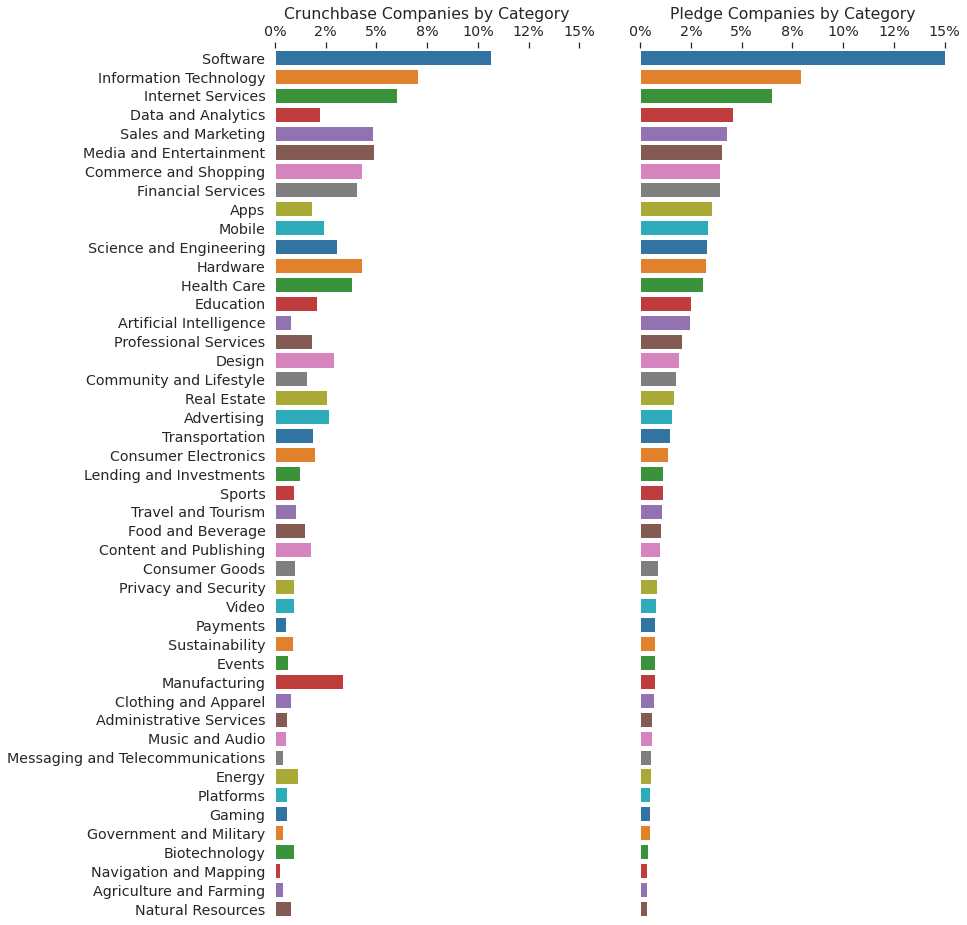

In [16]:
# Totals for Pledge 1% 
pledge1_industry_totals = pledge1_industry.iloc[pledge1_industry.shape[0]-1,:].to_list()[1:-1]

# Totals for Crunchbase
df_industry_totals = df_industry.iloc[-1,:].to_list()[1:-1]

# Save the order of the top P1 industries
groups_sorted = df_industry.columns.to_list()[1:-1]

# Create two dataframes for barplots
p1_industry_count = pd.DataFrame.from_dict({'Category':groups_sorted, 'Count':pledge1_industry_totals})
cb_industry_count = pd.DataFrame.from_dict({'Category':groups_sorted, 'Count':df_industry_totals})
p1_industry_count['Percent'] = round((p1_industry_count['Count']/p1_industry_count['Count'].sum())*100,2)
cb_industry_count['Percent'] = round((cb_industry_count['Count']/cb_industry_count['Count'].sum())*100,2)

# Barplots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 16), sharey=True)
xticks = ticker.FormatStrFormatter('%.0f%%')

# Crunchbase
sns.barplot(y='Category', x='Percent', data=cb_industry_count, palette ='tab10', orient='h', ax=ax[0])
ax[0].xaxis.set_ticks_position('top')
ax[0].xaxis.set_major_formatter(xticks)
ax[0].set_xlim([0,15])
ax[0].set_title('Crunchbase Companies by Category')
ax[0].set_ylabel('')
ax[0].set_xlabel('')

# Pledge 1%
sns.barplot(y='Category', x='Percent', data=p1_industry_count, palette ='tab10',orient='h', ax=ax[1])
ax[1].xaxis.set_ticks_position('top')
ax[1].xaxis.set_major_formatter(xticks)
ax[1].set_xlim([0,15])
ax[1].set_title('Pledge Companies by Category')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

# Display
sns.despine(left=True, bottom=True)
plt.show()